# Applied Machine Learning 2024: *Initial Project*
#### *Niels August Daivdsen (phx657)*
___

## First part: Classifying electrions from 25 parameters

In [37]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BDT packages
import xgboost as xgb
import lightgbm as lgb



In [38]:
### Set default plot parameters

# Font and fontsize
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Grid
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.color'] = 'white'
plt.rcParams['axes.grid'] = True

# Background color
plt.rcParams['axes.facecolor'] = 'gainsboro'

# Legend background color
plt.rcParams['legend.facecolor'] = 'white'


In [39]:
# Loading the training data
train_data = pd.read_csv("AppML_InitialProject_train.csv", sep=",")
input_data = train_data.drop(columns=['p_Truth_isElectron', 'p_Truth_Energy'])
truth_data = train_data['p_Truth_isElectron']                                   # Chech only if it is an electron
variables = input_data.columns.tolist()                                         # List of variables used in the model


# Loading the test data (for applying the model)
test_data = pd.read_csv("AppMl_InitialProject_test_classification.csv", sep=",")


# Splitting the training data using sklearn
from sklearn.model_selection import train_test_split
X_train, x_valid, Y_train, y_valid = train_test_split(input_data, truth_data, test_size=0.2, random_state=42)



### Deciding the most important parameters - Using Permutation Importance and SHAP-values

In [40]:
# Permutation importance
from sklearn.inspection import permutation_importance

model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    num_leaves=10,
    verbose=0,
    n_estimators=1000,
    early_stopping_rounds=20
)

# Fitting the model
model.fit(X_train, Y_train, eval_set=[(x_valid, y_valid)])

# Calculating the permutation importance
# perm_importance = permutation_importance(model, 
#     x_valid,
#     y_valid, 
#     n_repeats=10,
#     random_state=42
# )
# 
# sorted_idx = perm_importance.importances_mean.argsort()
# sort_variables = np.array(variables)[sorted_idx]
# 
# # Write sort_variables to a file
# with open("sort_variables.txt", "w") as f:
#     for var in sort_variables:
#         f.write(f"{var}\n")
#     # close the file
#     f.close()


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


LGBMClassifier(early_stopping_rounds=20, metric='binary_logloss',
               n_estimators=1000, num_leaves=10, objective='binary', verbose=0)

In [41]:
#fig, ax = plt.subplots(figsize=(20, 15))
#top_25_vars = sort_variables[-25:]
#low_25_vars = sort_variables[:25]
#
#ax.barh(top_25_vars, 
#        perm_importance.importances_mean[sorted_idx][-25:], 
#        xerr=perm_importance.importances_std[sorted_idx][-25:], 
#        align="center", 
#        color="C0", 
#        alpha=0.7,
#)
#
#
#ax.set_xlabel("Permutation Importance (mean ± std)")
#ax.set_title("Permutation Importance of Features")
#fig.tight_layout()
#
#plt.savefig("figures/Permutation_Importance.png", dpi=250)

/Users/nielsaugustdavidsen/Documents/GitHub/AppliedML2025_fork/appmlenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


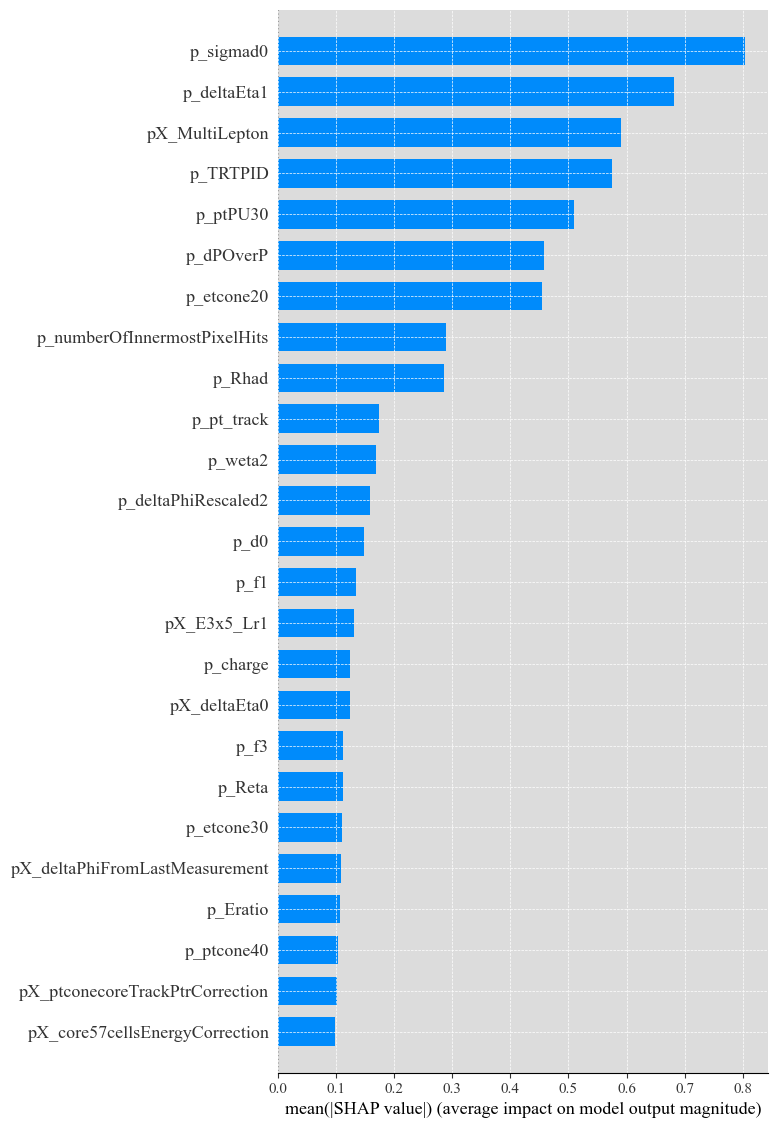

In [42]:
# Read the sorted variables from the file
with open("sort_variables.txt", "r") as f:
    sort_variables = [line.strip() for line in f.readlines()]
    # close the file
    f.close()

# SHAP values 
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(input_data)
shap.summary_plot(shap_values, 
                   input_data, 
                   feature_names=variables, 
                   max_display=25, 
                   plot_type="bar", 
                   color_bar=True,
)



### Boosted desicion trees (BDT) using LGBM

In [43]:
def quick_lbg_bdt(input_data, truth_data, model_params, nbr=1000, esr=20):
    """
    Function to quickly train a LightGBM BDT classifier and return the model and the predictions.
    """
    # Splitting the training data using sklearn
    from sklearn.model_selection import train_test_split
    X_train, x_valid, Y_train, y_valid = train_test_split(input_data, truth_data, test_size=0.2, random_state=42)

    lbg_train = lgb.Dataset(X_train, label=Y_train)
    lbg_test = lgb.Dataset(x_valid, label=y_valid)

    # Training the model
    model = lgb.train(
        model_params,
        train_set=lbg_train,
        valid_sets=lbg_test,
        num_boost_round=nbr,
        callbacks=[lgb.early_stopping(esr, verbose=True)],
    )

    # Getting the predictions
    y_pred = model.predict(x_valid, num_iteration=model.best_iteration)
    binary_score = np.where(y_pred > 0.5, 1, 0)
    
    return model, y_pred, binary_score

In [44]:



# Reshaping data according to the top 25 variables
reshap_data = input_data[sort_variables[-25:]].copy()


# Splitting the reshaped data into training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(reshap_data, truth_data, test_size=0.2, random_state=42)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 30,
    "verbose": 0,
    "learning_rate": 0.1
}

model, y_score, binary_score = quick_lbg_bdt(
    reshap_data,
    truth_data,
    model_params=params,
    nbr=1000,
    esr=20
)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[317]	valid_0's binary_logloss: 0.0667137


Text(0.5, 1.0, 'ROC curve for LightGBM Classifier (BDT) used on top 25 variables')

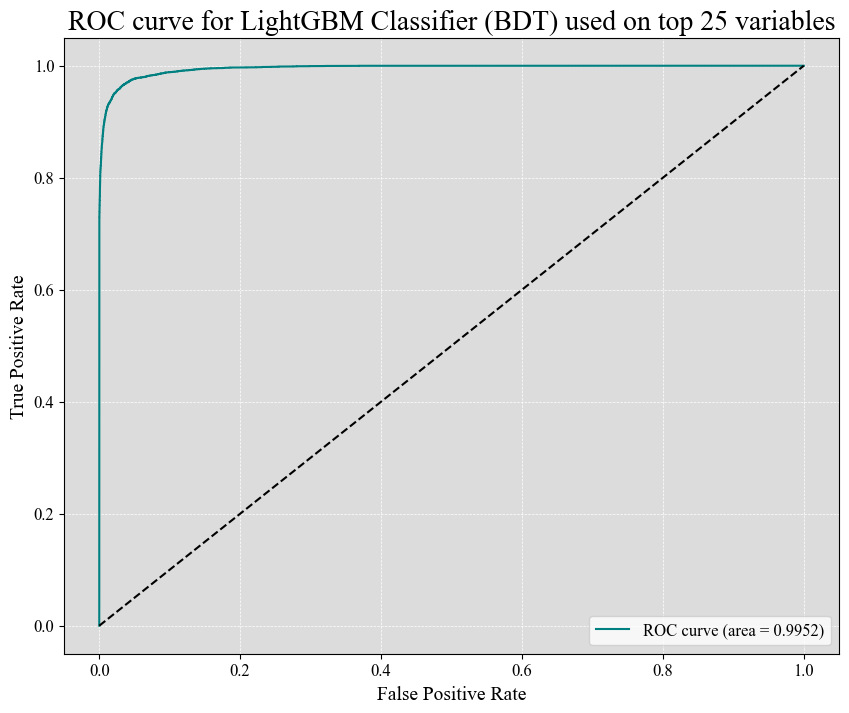

In [45]:
# Evaluating the model
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color="teal", label=f"ROC curve (area = {roc_auc:.4f})")
ax.plot([0, 1], [0, 1], color="k", linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.set_title("ROC curve for LightGBM Classifier (BDT) used on top 25 variables")

In [46]:
# Checking for overfitting

train_pred = model.predict(X_train)
train_auc = roc_auc_score(y_train, train_pred)

valid_pred = model.predict(X_valid)
valid_auc = roc_auc_score(y_valid, valid_pred)
print(f"Train AUC: {train_auc:.4f}")
print(f"Validation AUC: {valid_auc:.4f}")



Train AUC: 0.9992
Validation AUC: 0.9952


Text(0.5, 1.0, 'Predicted probability of being an electron (test data)')

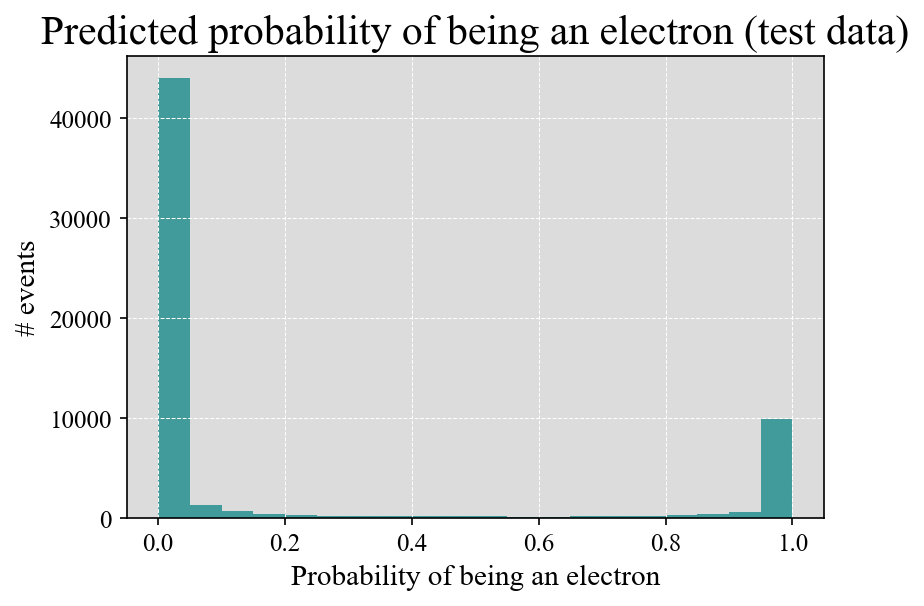

In [47]:
# Testing model against test data

test_pred = model.predict(test_data[sort_variables[-25:]], num_iteration=model.best_iteration)

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.hist(test_pred, bins=20, color="teal", alpha=0.7)
ax.set_xlabel("Probability of being an electron")
ax.set_ylabel("# events")
ax.set_title("Predicted probability of being an electron (test data)")




### Neural networks using PyTorch

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(test_data[sort_variables[-25:]])


In [50]:
class ClassificationDataset(Dataset):
   def __init__(self, X, y=None):
        # Handle X
        if isinstance(X, pd.Series):
            X = X.values.reshape(-1, 1)  # Make it 2D
        elif isinstance(X, pd.DataFrame):
            X = X.values
        X = np.asarray(X, dtype=np.float32)
        self.X = torch.from_numpy(X)

        # Handle y
        if y is not None:
            if isinstance(y, pd.Series):
                y = y.values
            y = np.asarray(y, dtype=np.float32).reshape(-1)  # Ensure it's 1D
            self.y = torch.from_numpy(y)
        else:
            self.y = None

   def __len__(self):
       return len(self.X)
   def __getitem__(self, idx):
       if self.y is not None:
           return self.X[idx], self.y[idx]
       else:
           return self.X[idx]
        
# Creating PyTorch datasets
train_data = ClassificationDataset(X_train_scaled, y_train)
valid_data = ClassificationDataset(X_valid_scaled, y_valid)
test_data = ClassificationDataset(X_test_scaled)

# Creating DataLoader objects
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [ ]:

# Define the neural network model
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

